In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
# define parameters
CLASS_NUM = 2
BATCH_SIZE = 3
#EPOCH_STEPS = int(4323/BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 3)
IMAGE_TRAIN = '/content/drive/MyDrive/prepro/clahee/train'
MODEL_NAME = '/content/drive/MyDrive/googlenet.h5'

In [ ]:
# prepare data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

generator_main = train_datagen.flow_from_directory(
    IMAGE_TRAIN,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

def my_generator(generator):
    while True: # keras requires all generators to be infinite
        data = next(generator)
        x = data[0]
        y = data[1], data[1], data[1]
        yield x, y

train_generator = my_generator(generator_main)

Found 49 images belonging to 2 classes.


In [ ]:
# create model
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model


In [ ]:
# train model
model = googlenet()
model.summary()
#model.load_weights(MODEL_NAME)
#tf.keras.utils.plot_model(model, 'GoogLeNet.png')

#optimizer = Adam(lr=2 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#optimizer = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

optimizer = ['Adam']
epochs = [50]
history_all = {}

for i in range(len(optimizer)):
    print('Usnig optimizer: ' + optimizer[i] + ', Epoch: ' + str(epochs[i]))
    
    model.compile(loss='categorical_crossentropy', 
                  loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  optimizer=optimizer[i], metrics=['accuracy'])
    
    train_history = model.fit_generator(
            train_generator,
            steps_per_epoch=50,
            epochs=epochs[i],
            #callbacks=[checkpoint]
            shuffle=True
            )
    
    # save history    
    if len(history_all) == 0:
        history_all = {key: [] for key in train_history.history}
    
    for key in history_all:
        history_all[key].extend(train_history.history[key])

model.save(MODEL_NAME)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_59 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_59[0][0]']              
 )                                                                                          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
50/50 [==============================] - 49s 903ms/step - loss: 5.1675 - main_loss: 4.4576 - aux1_loss: 0.9478 - aux2_loss: 1.4186 - main_accuracy: 0.6667 - aux1_accuracy: 0.6319 - aux2_accuracy: 0.6875
Epoch 2/50
50/50 [==============================] - 45s 892ms/step - loss: 1.0029 - main_loss: 0.6244 - aux1_loss: 0.6222 - aux2_loss: 0.6393 - main_accuracy: 0.7083 - aux1_accuracy: 0.7083 - aux2_accuracy: 0.7083
Epoch 3/50
50/50 [==============================] - 44s 883ms/step - loss: 0.9708 - main_loss: 0.6051 - aux1_loss: 0.6124 - aux2_loss: 0.6066 - main_accuracy: 0.7153 - aux1_accuracy: 0.7153 - aux2_accuracy: 0.7153
Epoch 4/50
50/50 [==============================] - 44s 889ms/step - loss: 1.0853 - main_loss: 0.6686 - aux1_loss: 0.7044 - aux2_loss: 0.6844 - main_accuracy: 0.6458 - aux1_accuracy: 0.6389 - aux2_accuracy: 0.6458
Epoch 5/50
50/50 [==============================] - 44s 883ms/step - loss: 0.9943 - main_loss: 0.6149 - aux1_loss: 0.6475 - aux2_loss: 0.6171 - 

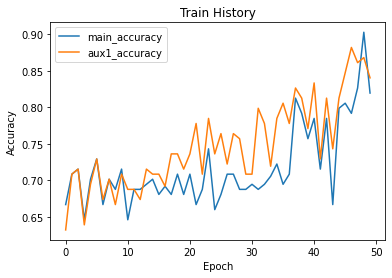

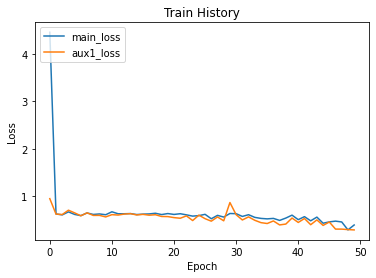

In [ ]:
# show train history
def show_train_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

show_train_history(history_all, 'Epoch', 'Accuracy', ('main_accuracy', 'aux1_accuracy'))
show_train_history(history_all, 'Epoch', 'Loss', ('main_loss', 'aux1_loss'))

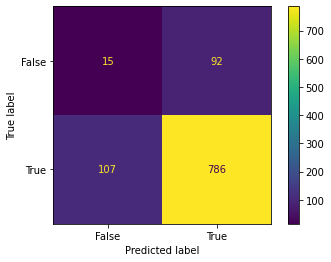

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()